## 0. Импорт библиотек, определение функций

In [1]:
import pandas as pd

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

import numpy as np
from scipy.stats import kstest, spearmanr, mannwhitneyu, levene, kruskal

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler,  PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold
import statsmodels.api as sm

import operator

from datetime import datetime

from collections import Counter

from matplotlib.colors import ListedColormap 

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, auc, classification_report, precision_recall_curve, auc, classification_report
from sklearn.utils import shuffle
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score

In [2]:
def get_spearman(data_1, data_2):
    correlation = spearmanr(data_1, data_2)
    return '{0:.2f}\n{1:.2f}'.format(*correlation)

In [3]:
def conf_matrix(fact, pred):
    conf_test = confusion_matrix(fact, pred, normalize='true')
    sns.heatmap(conf_test, annot=True, fmt='.2f', cmap='binary')
    plt.xlabel('Predicted', size=14)
    plt.ylabel('Actual', size=14)
    plt.show()

## 1. Импорт данных и предобработка

In [4]:
ds = pd.read_csv('data/spotify_data.csv', index_col='Unnamed: 0')
ds.head()

,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3
1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4
2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4
3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4
4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4


Создание новых признаков: 
- возраст трека;
- длительность в минутах;
- популярность, как качественный показатель: если исходная популярность больше 50, то трек считается популярным.

In [5]:
len(ds)

1159764

In [5]:
ds['age'] = (datetime.today().year - ds['year']).astype('int')

In [6]:
ds['duration_min'] = ds['duration_ms']//1000//60

In [7]:
ds['popularity'] = ds['popularity'].apply(lambda x: 1 if x>=50 else 0)

Разделение признаков на группы.

In [8]:
categorial_data = ['popularity','artist_name', 'track_name', 'track_id', 'year', 'genre', 'key', 'mode','time_signature']
metric = ['danceability', 'energy', 'loudness','speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_min', 'age' ]

В качестве неинформативных категориальных признаков были выделены track_id, track_name и artist_name, поэтому они исключаются из дальнейшего рассмотрения

Обнаружена высокая достоверная корреляция между признаками:
energy и acousticness (-0,73)   
energy и loudness (0,73)   
energy и speechiness (0,36)   
loudness и acousticness (-0,57)   
danceability и valence (0,51)   
instrumentalness и valence (-0,35)   

   Выберем age, liveness, acousticness и valence

# Лучшая модель (из предыдущих)

In [9]:
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
from pactools.grid_search import GridSearchCVProgressBar

In [10]:
ds_new = ds[['popularity', 'age', 'tempo']]

In [11]:
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(
    ds_new.drop('popularity', axis =1), 
    ds_new['popularity'], 
    test_size=0.2, 
    random_state=21)

In [12]:
np.random.seed(666)
new_rand_index = np.random.choice(new_X_train.index,10000)
new_X_train_learn = new_X_train.loc[new_rand_index]
new_y_train_learn = new_y_train.loc[new_rand_index]

In [31]:
new_model = svm.SVC(C = 1000, probability = True, class_weight = 'balanced',  degree =  2, kernel= 'poly')

In [32]:
new_model.fit(new_X_train_learn, new_y_train_learn)

SVC(C=1000, class_weight='balanced', degree=2, kernel='poly', probability=True)

In [33]:
y_approx_new = new_model.predict(new_X_train_learn)
y_pred_new = new_model.predict(new_X_test)

In [34]:
print(classification_report(new_y_test, y_pred_new))

              precision    recall  f1-score   support

           0       0.98      0.58      0.73    221444
           1       0.08      0.76      0.14     10509

    accuracy                           0.58    231953
   macro avg       0.53      0.67      0.43    231953
weighted avg       0.94      0.58      0.70    231953



код для roc-auc

In [36]:
probabilities_svc_new = new_model.predict_proba(new_X_train_learn)
fpr_new, tpr_new, th_new = roc_curve(new_y_train_learn, probabilities_svc_new[:,1])
mod_new_roc_auc = auc(fpr_new[:-1], tpr_new[:-1])

# Дерево решений

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [18]:
from pactools.grid_search import GridSearchCVProgressBar

1. Провести классификацию с помощью решающего дерева по 2-м признакам. Для разных критериев остановки подобрать оптимальное значения гиперпараметров: критерий деления и значение для остановки. Например, если выбран критерий остановки "max_depth" (максимальная глубина дерева), то сетка будет выглядеть так: {'criterion':['gini', 'entropy'], 'max_depth': range(1,10)}. 
Оценить качество полученной модели. Сравнить с лучшим результатом, достигнутым ранее.
P.S. при построении модели учесть дисбаланс классов.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    ds_new.drop('popularity', axis =1), 
    ds_new['popularity'], 
    test_size=0.2, 
    random_state=21)

### Критерий остановки - максимальная глубина 

In [21]:
grid = {'criterion':['gini', 'entropy'], 'max_depth': range(1,10)}
model_dt = DecisionTreeClassifier(class_weight = 'balanced', random_state=123)
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

In [25]:
gs = GridSearchCV(model_dt, grid, cv = skf, scoring = 'roc_auc', verbose=3)

In [26]:
gs.fit(X_train, y_train) 

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4] END .......criterion=gini, max_depth=1;, score=0.675 total time=   0.2s
[CV 2/4] END .......criterion=gini, max_depth=1;, score=0.680 total time=   0.3s
[CV 3/4] END .......criterion=gini, max_depth=1;, score=0.679 total time=   0.2s
[CV 4/4] END .......criterion=gini, max_depth=1;, score=0.682 total time=   0.3s
[CV 1/4] END .......criterion=gini, max_depth=2;, score=0.706 total time=   0.4s
[CV 2/4] END .......criterion=gini, max_depth=2;, score=0.708 total time=   0.4s
[CV 3/4] END .......criterion=gini, max_depth=2;, score=0.708 total time=   0.4s
[CV 4/4] END .......criterion=gini, max_depth=2;, score=0.712 total time=   0.4s
[CV 1/4] END .......criterion=gini, max_depth=3;, score=0.713 total time=   0.6s
[CV 2/4] END .......criterion=gini, max_depth=3;, score=0.718 total time=   0.6s
[CV 3/4] END .......criterion=gini, max_depth=3;, score=0.718 total time=   0.6s
[CV 4/4] END .......criterion=gini, max_depth=3;

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=123),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10)},
             scoring='roc_auc', verbose=3)

In [29]:
gs.best_params_

{'criterion': 'gini', 'max_depth': 7}

In [27]:
model = gs.best_estimator_

In [28]:
knn_pred_1 = model.predict(X_test)
target_names = y_train.unique()
print(classification_report(y_test, knn_pred_1, labels=target_names))

              precision    recall  f1-score   support

           0       0.98      0.66      0.79    221444
           1       0.09      0.70      0.16     10509

    accuracy                           0.66    231953
   macro avg       0.53      0.68      0.47    231953
weighted avg       0.94      0.66      0.76    231953



Сравнивая с предыдущими моделями, метрика precision не изменилась, recall для класса 0 увеличился, но в то же время recall для класса 1 снизился.

In [40]:
probabilities_dt = model.predict_proba(X_train)
fpr, tpr, th = roc_curve(y_train, probabilities_dt[:,1])
mod_roc_auc = auc(fpr[:-1], tpr[:-1])

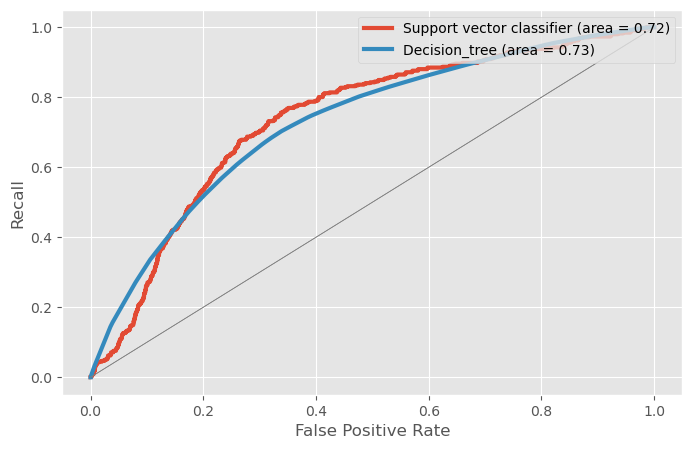

In [43]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(fpr_new, tpr_new, linewidth = 3,label = 'Support vector classifier (area = %0.2f)' % mod_new_roc_auc)
ax.plot(fpr, tpr, linewidth = 3,label = 'Decision_tree (area = %0.2f)' % mod_roc_auc)
plt.plot([[0,0],[1,1]], linewidth=0.5, color='gray')
plt.legend(loc = "upper right")
plt.xlabel('False Positive Rate',fontsize = 12)
plt.ylabel('Recall',fontsize = 12)
plt.show()

Метрика ROC-AUC стала незначительно лучше

### Критерий остановки - min_samples_leaf

In [51]:
grid1 = {'criterion':['gini', 'entropy'], 'min_samples_leaf': [50,100, 200, 300, 500,700]}
model_dt = DecisionTreeClassifier(class_weight = 'balanced', random_state=123)
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

In [52]:
gs = GridSearchCV(model_dt, grid1, cv = skf, scoring = 'roc_auc', verbose=3)
gs.fit(X_train, y_train)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV 1/4] END criterion=gini, min_samples_leaf=50;, score=0.673 total time=   3.8s
[CV 2/4] END criterion=gini, min_samples_leaf=50;, score=0.676 total time=   3.7s
[CV 3/4] END criterion=gini, min_samples_leaf=50;, score=0.676 total time=   3.7s
[CV 4/4] END criterion=gini, min_samples_leaf=50;, score=0.680 total time=   3.7s
[CV 1/4] END criterion=gini, min_samples_leaf=100;, score=0.693 total time=   3.4s
[CV 2/4] END criterion=gini, min_samples_leaf=100;, score=0.696 total time=   3.4s
[CV 3/4] END criterion=gini, min_samples_leaf=100;, score=0.698 total time=   3.4s
[CV 4/4] END criterion=gini, min_samples_leaf=100;, score=0.700 total time=   3.4s
[CV 1/4] END criterion=gini, min_samples_leaf=200;, score=0.706 total time=   3.0s
[CV 2/4] END criterion=gini, min_samples_leaf=200;, score=0.709 total time=   2.9s
[CV 3/4] END criterion=gini, min_samples_leaf=200;, score=0.711 total time=   3.0s
[CV 4/4] END criterion=gini, m

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=123),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [50, 100, 200, 300, 500, 700]},
             scoring='roc_auc', verbose=3)

In [53]:
model1 = gs.best_estimator_
knn_pred_1 = model1.predict(X_test)
target_names = y_train.unique()
print(classification_report(y_test, knn_pred_1, labels=target_names))

              precision    recall  f1-score   support

           0       0.98      0.67      0.79    221444
           1       0.09      0.69      0.16     10509

    accuracy                           0.67    231953
   macro avg       0.53      0.68      0.48    231953
weighted avg       0.94      0.67      0.76    231953



In [54]:
probabilities_dt1 = model1.predict_proba(X_train)
fpr_1, tpr_1, th_1 = roc_curve(y_train, probabilities_dt1[:,1])
mod_roc_auc_1 = auc(fpr_1[:-1], tpr_1[:-1])

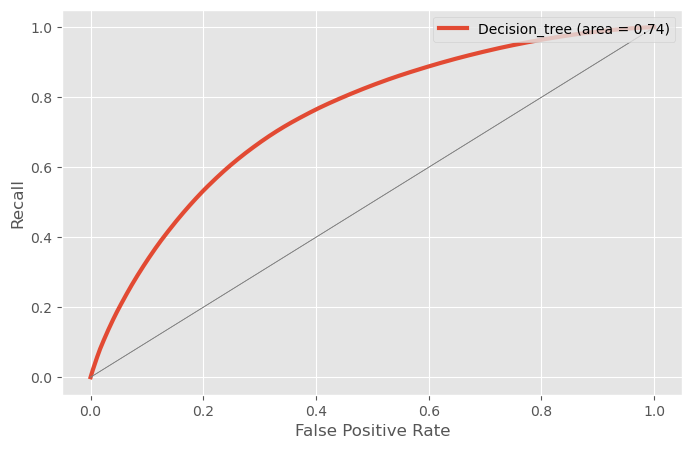

In [55]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(fpr_1, tpr_1, linewidth = 3,label = 'Decision_tree (area = %0.2f)' % mod_roc_auc_1)
plt.plot([[0,0],[1,1]], linewidth=0.5, color='gray')
plt.legend(loc = "upper right")
plt.xlabel('False Positive Rate',fontsize = 12)
plt.ylabel('Recall',fontsize = 12)
plt.show()

Предыдущая модель была лучше, остаемся на ней

# Добавление факторов

In [56]:
ds_n = ds[['popularity', 'age', 'liveness', 'tempo', 'mode', 'danceability']]

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    ds_n.drop('popularity', axis =1), 
    ds_n['popularity'], 
    test_size=0.2, 
    random_state=21)

In [59]:
grid_n = {'criterion':['gini', 'entropy'], 'max_depth': range(1,10)}
model_dt = DecisionTreeClassifier(class_weight = 'balanced', random_state=123)
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
gs_n = GridSearchCV(model_dt, grid_n, cv = skf, scoring = 'roc_auc', verbose=3)
gs_n.fit(X_train, y_train) 

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4] END .......criterion=gini, max_depth=1;, score=0.675 total time=   0.3s
[CV 2/4] END .......criterion=gini, max_depth=1;, score=0.680 total time=   0.3s
[CV 3/4] END .......criterion=gini, max_depth=1;, score=0.679 total time=   0.4s
[CV 4/4] END .......criterion=gini, max_depth=1;, score=0.682 total time=   0.3s
[CV 1/4] END .......criterion=gini, max_depth=2;, score=0.711 total time=   0.6s
[CV 2/4] END .......criterion=gini, max_depth=2;, score=0.716 total time=   0.6s
[CV 3/4] END .......criterion=gini, max_depth=2;, score=0.713 total time=   0.7s
[CV 4/4] END .......criterion=gini, max_depth=2;, score=0.719 total time=   0.6s
[CV 1/4] END .......criterion=gini, max_depth=3;, score=0.731 total time=   0.9s
[CV 2/4] END .......criterion=gini, max_depth=3;, score=0.734 total time=   0.9s
[CV 3/4] END .......criterion=gini, max_depth=3;, score=0.733 total time=   0.9s
[CV 4/4] END .......criterion=gini, max_depth=3;

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=123),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10)},
             scoring='roc_auc', verbose=3)

In [62]:
model2 = gs_n.best_estimator_
knn_pred_1 = model2.predict(X_test)
target_names = y_train.unique()
print(classification_report(y_test, knn_pred_1, labels=target_names))

              precision    recall  f1-score   support

           0       0.98      0.73      0.83    221444
           1       0.10      0.67      0.18     10509

    accuracy                           0.73    231953
   macro avg       0.54      0.70      0.51    231953
weighted avg       0.94      0.73      0.81    231953



recall для 0 увеличился

In [63]:
probabilities_dt2 = model2.predict_proba(X_train)
fpr_2, tpr_2, th_2 = roc_curve(y_train, probabilities_dt2[:,1])
mod_roc_auc_2 = auc(fpr_2[:-1], tpr_2[:-1])

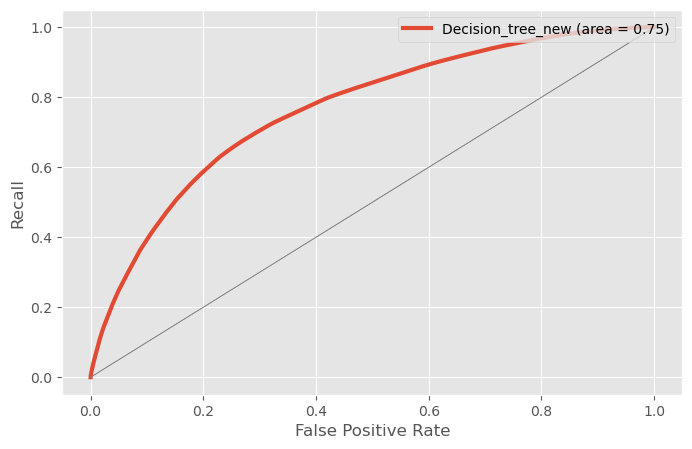

In [64]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(fpr_2, tpr_2, linewidth = 3,label = 'Decision_tree_new (area = %0.2f)' % mod_roc_auc_2)
plt.plot([[0,0],[1,1]], linewidth=0.5, color='gray')
plt.legend(loc = "upper right")
plt.xlabel('False Positive Rate',fontsize = 12)
plt.ylabel('Recall',fontsize = 12)
plt.show()

Метрика roc-auc не изменилась

# Выводы

1) В сравнении с предыдущими моделями дерево решений показало хорошие результаты, с 2 признаками оно показало лучший результат.
2) К преимуществам этой модели я отнесу высокую вариативность, т.к. существует много параметров, которые можно подбирать оптимальным образом.

3) Что касается нашей модели, то в данном случае немного увеличился recall и roc-auc, но в целом, для улучшения модели необходимо подобрать лучшие факторы, либо применить иную модель с оптимальными параметрами.